<a href="https://colab.research.google.com/github/noahgift/edge-computer-vision/blob/master/computer_vision_lecture2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emerging Computer Vision Technologies

## Neural Network Quick Guide

#### Deep Learning Basics

* [MIT Deep Learning Basics: Introduction and Overview with TensorFlow](https://medium.com/tensorflow/mit-deep-learning-basics-introduction-and-overview-with-tensorflow-355bcd26baf0)

References:  [Tensorflow playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.17288&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

## Generative Modeling

**Generative** models can generate new data instances.

* References
    - [Music Generative Modeling in Colab](https://magenta.tensorflow.org/demos/colab/)
    - https://developers.google.com/machine-learning/gan/generative

### TF-Hub generative image model DEMO

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf_hub_generative_image_module.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf_hub_generative_image_module.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>


This Colab demonstrates use of a TF-Hub module based on a generative adversarial network (GAN). The module maps from N-dimensional vectors, called latent space, to RGB images.

Two examples are provided:
* **Mapping** from latent space to images, and
* Given a target image, **using gradient descent to find** a latent vector that generates an image similar to the target image.

#### Optional prerequisites

* Familiarity with [low level Tensorflow concepts](https://www.tensorflow.org/guide/low_level_intro).
* [Generative Adversarial Network](https://en.wikipedia.org/wiki/Generative_adversarial_network) on Wikipedia.
* Paper on Progressive GANs: [Progressive Growing of GANs for Improved Quality, Stability, and Variation](https://arxiv.org/abs/1710.10196).

In [ ]:
# Install the latest Tensorflow version.
!pip -q install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip -q install tensorflow-hub
# Install imageio for creating animations.  
!pip -q install imageio
!pip -q install scikit-image

In [ ]:
#@title Imports and function definitions

from absl import logging

import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512


# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)


# Given a set of images, show an animation.
def animate(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  with open('./animation.gif','rb') as f:
      display.display(display.Image(data=f.read(), height=300))


# Simple way to display an image.
def display_image(image):
  plt.figure()
  plt.axis("off")
  plt.imshow(image)


# Display multiple images in the same figure.
def display_images(images, captions=None):
  num_horizontally = 5
  f, axes = plt.subplots(
      len(images) // num_horizontally, num_horizontally, figsize=(20, 20))
  for i in range(len(images)):
    axes[i // num_horizontally, i % num_horizontally].axis("off")
    if captions is not None:
      axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
    axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
  f.tight_layout()

logging.set_verbosity(logging.ERROR)

#### Latent space interpolation

##### Random vectors

Latent space interpolation between two randomly initialized vectors. We will use a TF-Hub module [progan-128](https://tfhub.dev/google/progan-128/1) that contains a pre-trained Progressive GAN.

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


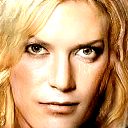

In [ ]:
def interpolate_between_vectors():
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    # Change the seed to get different random vectors.
    v1 = tf.random_normal([latent_dim], seed=3)
    v2 = tf.random_normal([latent_dim], seed=1)
    
    # Creates a tensor with 50 steps of interpolation between v1 and v2.
    vectors = interpolate_hypersphere(v1, v2, 25)

    # Uses module to generate images from the latent space.
    interpolated_images = module(vectors)

    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      interpolated_images_out = session.run(interpolated_images)

    animate(interpolated_images_out)

interpolate_between_vectors()

#### Finding closest vector in latent space
Fix a target image. As an example use an image generated from the module or upload your own.

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


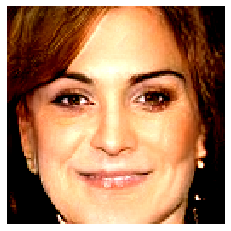

In [ ]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")
    vector = tf.random_normal([1, latent_dim], seed=4)
    images = module(vector)

    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      image_out = session.run(images)[0]
  return image_out

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()
display_image(target_image)

After defining a loss function between the target image and the image generated by a latent space variable, we can use gradient descent to find variable values that minimize the loss.

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0.6887691
5.607328
5.0491366
2.7256765
0.7315468
1.4969732
0.82849556
1.1469867
1.4737513
0.7809693
0.87811846
1.2610424
0.8297322
0.51274157
0.7656678
0.28113756
1.0128437
1.3109108
0.95774573
0.17565724
0.38898572
0.22725585
0.20067665
0.37999085
0.14685208
0.8291529
0.95335776
0.5000882
0.6411725
0.94266456
0.68878233
0.25481758
0.40401965
0.17221221
0.1862027
0.35617867
0.16504133
0.6994633
0.7984366
0.37147254


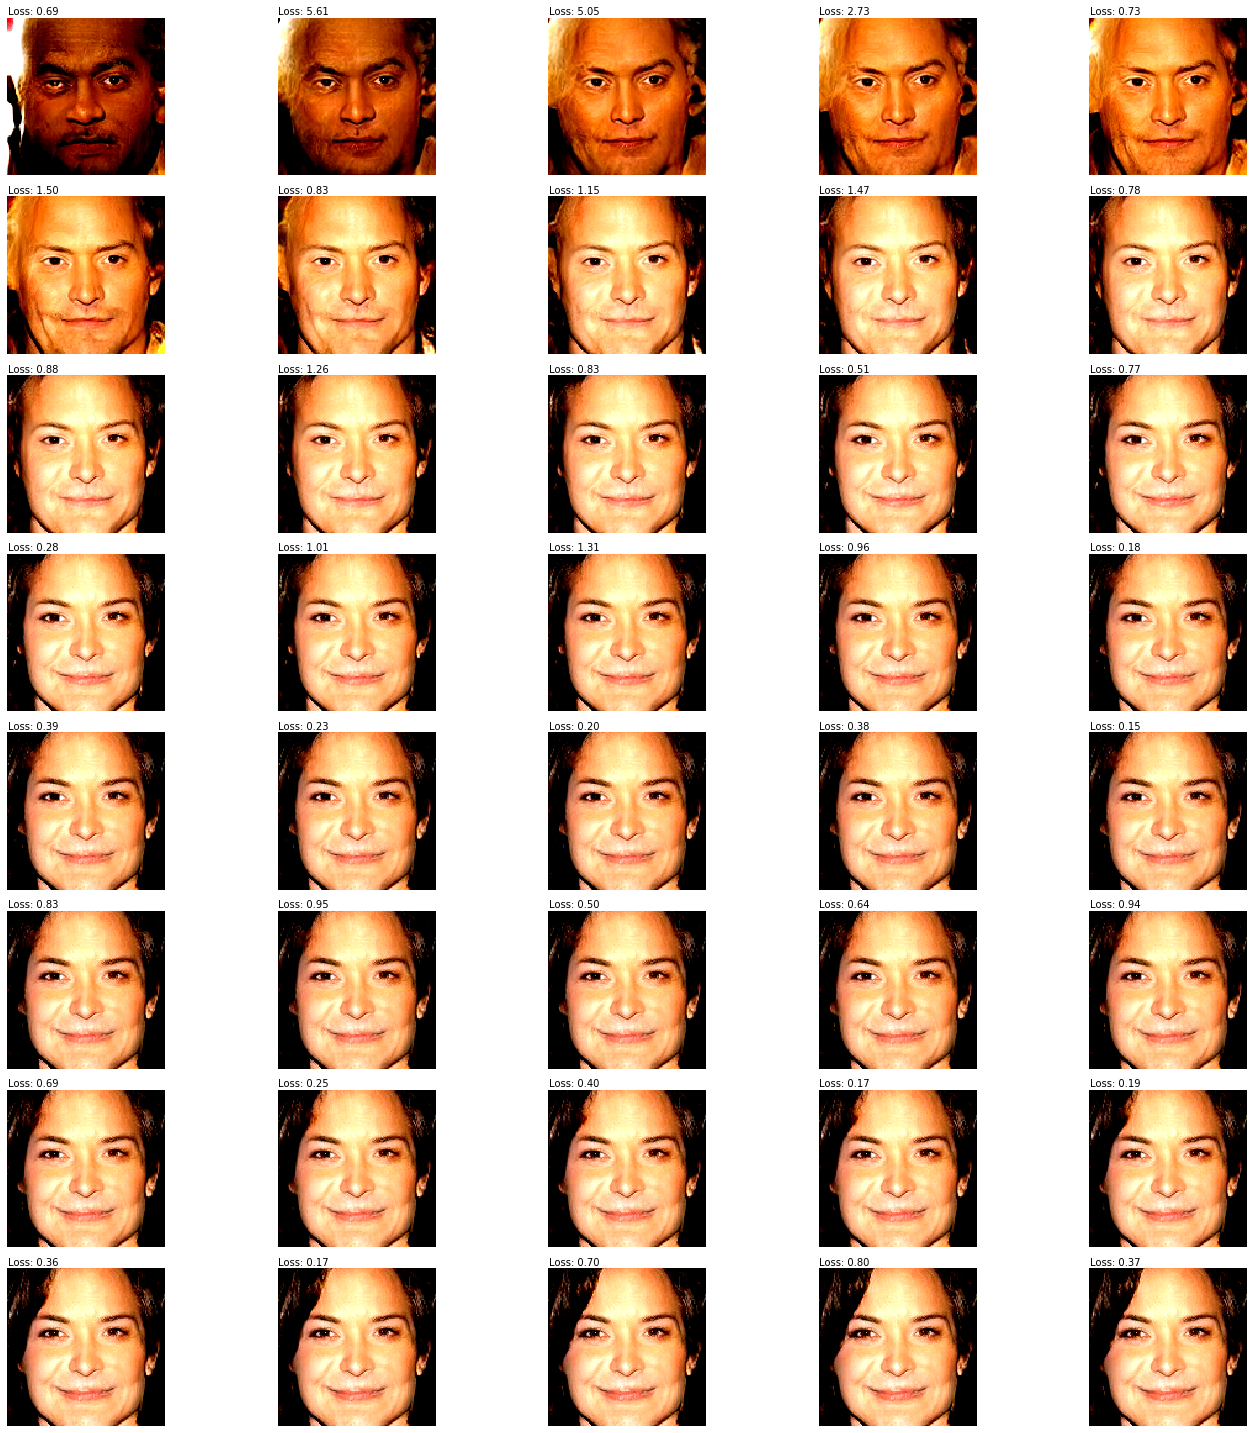

In [ ]:
def find_closest_latent_vector(num_optimization_steps):
  images = []
  losses = []
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    initial_vector = tf.random_normal([1, latent_dim], seed=5)

    vector = tf.get_variable("vector", initializer=initial_vector)
    image = module(vector)

    target_image_difference = tf.reduce_sum(
        tf.losses.absolute_difference(image[0], target_image[:,:,:3]))

    # The latent vectors were sampled from a normal distribution. We can get
    # more realistic images if we regularize the length of the latent vector to 
    # the average length of vector from this distribution.
    regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
    
    loss = target_image_difference + regularizer
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.3)
    train = optimizer.minimize(loss)

    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      for _ in range(num_optimization_steps):
        _, loss_out, im_out = session.run([train, loss, image])
        images.append(im_out[0])
        losses.append(loss_out)
        print(loss_out)
    return images, losses


result = find_closest_latent_vector(num_optimization_steps=40)
display_images(result[0], [("Loss: %.2f" % loss) for loss in result[1]])

### Playing with the above example
If image is from the module space, the descent is quick and converges to a reasonable sample. Try out descending to an image that is **not from the module space**. The descent will only converge if the image is reasonably close to the space of training images.

How to make it descend faster and to a more realistic image? One can try:
* using different loss on the image difference, e.g. quadratic,
* using different regularizer on the latent vector,
* initializing from a random vector in multiple runs,
* etc.


## Transfer Learning

* Reference:  https://codelabs.developers.google.com/codelabs/keras-flowers-transfer-learning/#3

Core Concepts:

* General idea is to build from existing **knowledge**

### Imports

In [ ]:
import os, math, json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
tf.enable_eager_execution()
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 1.15.0


### Colab-only auth
You would need this if you were accessing private GCS buckets. The training data for this exercise is in a public bucket for which authentication is not necessary.

In [ ]:
# IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
# if IS_COLAB_BACKEND:
#   from google.colab import auth
#   auth.authenticate_user()  # not necessary to access a public bucket but you will probably want to access your private buckets too
  
HAS_COLAB_TPU = 'COLAB_TPU_ADDR' in os.environ
assert not HAS_COLAB_TPU, "Please select a GPU backend for this notebook. Pre-trained models in tf.keras.applications.* are not yet TPU-compatible"

### Configuration

In [ ]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS = 10

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.gfile.Glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


In [ ]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

### Read images and labels from TFRecords

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
  # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  dataset = dataset.with_options(option_no_order)
  #dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

In [ ]:
display_9_images_from_dataset(load_dataset(training_filenames))

InvalidArgumentError: ignored

<Figure size 936x936 with 0 Axes>

### training and validation datasets

In [ ]:
def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder will be needed on TPU
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  # For proper ordering of map/batch/repeat/prefetch, see Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets
  return dataset

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames)
validation_dataset = get_batched_dataset(validation_filenames)

### Model 


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

### QUESTION 1.
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9412608/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 46080)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 230405    
Total params: 2,488,389
Trainable params: 230,405
Non-trainable params: 2,257,984
_________________________________________________________________


### Training

In [ ]:
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps)

Train for 46 steps, validate for 10 steps
Epoch 1/10
46/46 [==============================] - 16s 348ms/step - loss: 2.1233 - acc: 0.7092 - val_loss: 1.8967 - val_acc: 0.7344
Epoch 2/10
46/46 [==============================] - 3s 72ms/step - loss: 0.3147 - acc: 0.9361 - val_loss: 2.1243 - val_acc: 0.7109
Epoch 3/10
46/46 [==============================] - 3s 70ms/step - loss: 0.1105 - acc: 0.9755 - val_loss: 1.5326 - val_acc: 0.7703
Epoch 4/10
46/46 [==============================] - 3s 72ms/step - loss: 0.0452 - acc: 0.9854 - val_loss: 1.7413 - val_acc: 0.7672
Epoch 5/10
46/46 [==============================] - 3s 71ms/step - loss: 0.0331 - acc: 0.9895 - val_loss: 2.0705 - val_acc: 0.7203
Epoch 6/10
46/46 [==============================] - 3s 71ms/step - loss: 0.0253 - acc: 0.9952 - val_loss: 2.3309 - val_acc: 0.7234
Epoch 7/10
46/46 [==============================] - 3s 71ms/step - loss: 0.0120 - acc: 0.9959 - val_loss: 1.6507 - val_acc: 0.7672
Epoch 8/10
46/46 [=====================

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


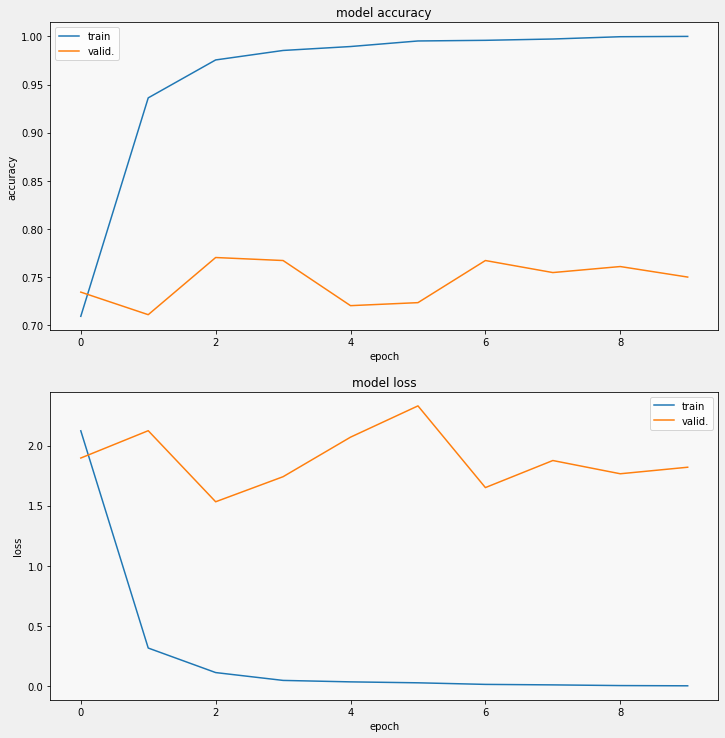

In [ ]:
print(history.history.keys())
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

### Predictions

In [ ]:
# random input: execute multiple times to change results
flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

['dandelion', 'dandelion', 'daisy', 'daisy', 'daisy', 'dandelion', 'dandelion', 'tulips', 'dandelion']


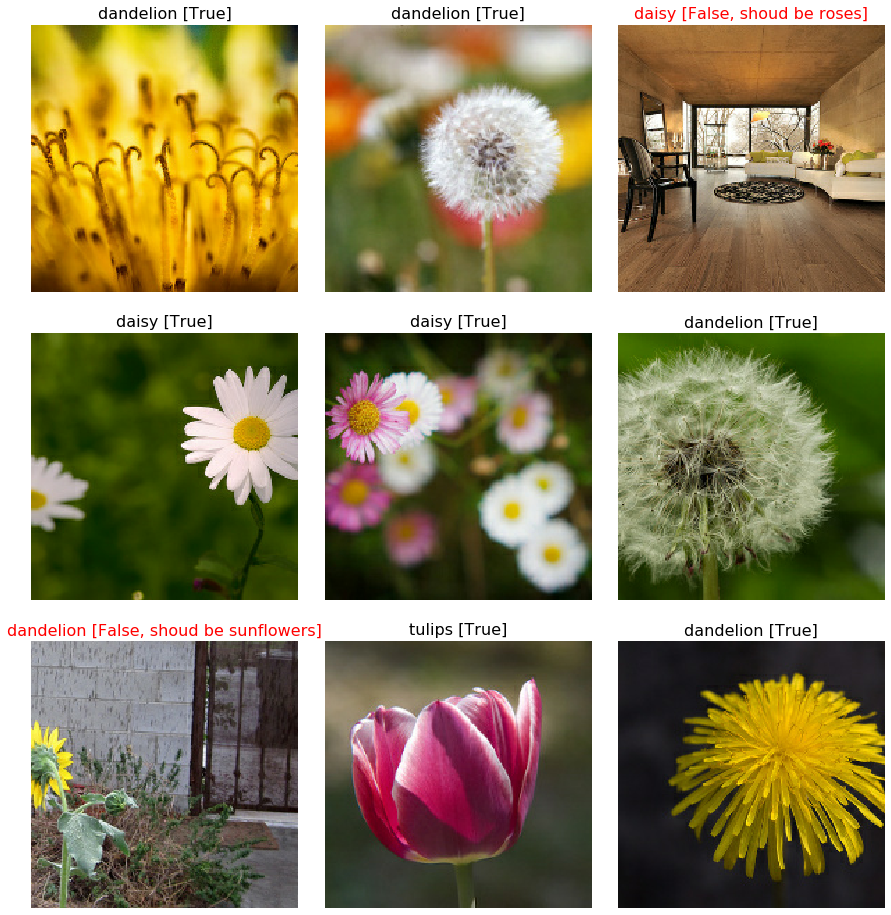

In [ ]:
display_9_images_with_predictions(flowers, predictions, labels)

## Open Gym

* Reference:  https://gym.openai.com/docs/

![action-reward](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

In [ ]:
!pip install gym

In [ ]:
import gym
env = gym.make('CartPole-v0')

In [ ]:
from gym import envs
myenvs = envs.registry.all()
print(len(myenvs))
#print(envs.registry.all())

859


### Pacman Open Gym Demo

## Ideas for Training Pacman Model:


Rewards to train:

* Avoid Ghosts
* Eat the energizer pellets
* Go Left
* Go Right
* Randomly go (right| left)
* Eat regular pellets
* Find open space (no pellets, no ghosts)
* Train it to find a new item: [Step 1- Eat pellet, A. go toward ghost, B. go to empty space, C. eat another pellet ]

- Example of Rewards:  https://www.digitalocean.com/community/tutorials/how-to-build-atari-bot-with-openai-gym

- https://www.digitalocean.com/community/tutorials/how-to-build-atari-bot-with-openai-gym


In [ ]:
from random import choices

In [ ]:
actions = ["eat pellet", "go toward ghost", "empty space"]
print(choices(actions))

['go toward ghost']


In [ ]:
def actions_list(actions):
    while True:
        for action in actions:
            yield choices(actions)


In [ ]:
actions = ["eat pellet", "go toward ghost", "empty space"]
actions2 = ["left", "right", "stay"]

In [ ]:
action = actions_list(actions2)

In [ ]:
for _ in range(5):
    print(next(action))

['left']
['left']
['right']
['stay']
['stay']


#### install dependancies, takes around 45 seconds

Rendering Dependancies



In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Pacman Dependancies

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (42.0.2)


#### Imports and Helper functions


In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

#### Pacman!

In [ ]:
env = wrap_env(gym.make("MsPacman-v0"))

In [ ]:
#check out the pacman action space!
print(env.action_space)

Discrete(9)


In [ ]:
observation = env.reset()

while True:
  
    env.render()
    
    #your agent goes here
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
        
    if done: 
      break;
            
env.close()
show_video()

NameError: ignored

## BlackJack

In [2]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """Simple blackjack environment

    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).

    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).

    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.

    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.

    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).

    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()